### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
429,PSID245,0,21,13,0,0,0,0,513.3279,578.2742,0.000
47,NSW48,1,17,9,1,0,0,1,0.0000,0.0000,0.000
138,NSW139,1,29,12,1,0,0,0,10881.9400,1817.2840,0.000
248,PSID64,0,40,15,0,0,1,0,10907.2400,5922.3870,6238.962
302,PSID118,0,20,11,1,0,0,1,0.0000,3480.3870,5495.665
469,PSID285,0,17,10,0,0,0,1,0.0000,152.1774,10301.230
155,NSW156,1,25,13,1,0,0,0,12362.9300,3090.7320,0.000
487,PSID303,0,52,12,0,0,1,0,14780.7100,0.0000,25564.670
449,PSID265,0,19,8,0,1,0,1,368.3422,300.7742,18510.000
518,PSID334,0,19,9,0,1,0,1,1822.1180,0.0000,3372.172


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

---

To analyse the relationship the relationship between the final earning `re78` within the two groups we may compare the numerical statistics, such as the mean, median, ... in the two groups. Visually, we can plot the histogram or the boxplots of the two groups.

In [3]:
treatment = df["treat"] == 1

# Numerical summaries
treat = df[treatment]["re78"].describe().rename("With Training")
no_treat = df[~treatment]["re78"].describe().rename("No Training")
pd.concat([treat, no_treat], axis=1)

,With Training,No Training
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


From the numerical summaries it seems that the mean and median salary in the group of people that have not visited the seminar is higher. For example, the average total earning is `~7000` for people that haven't visited the seminar, while the average earning is around `~6350` for the people that have visited the seminar.

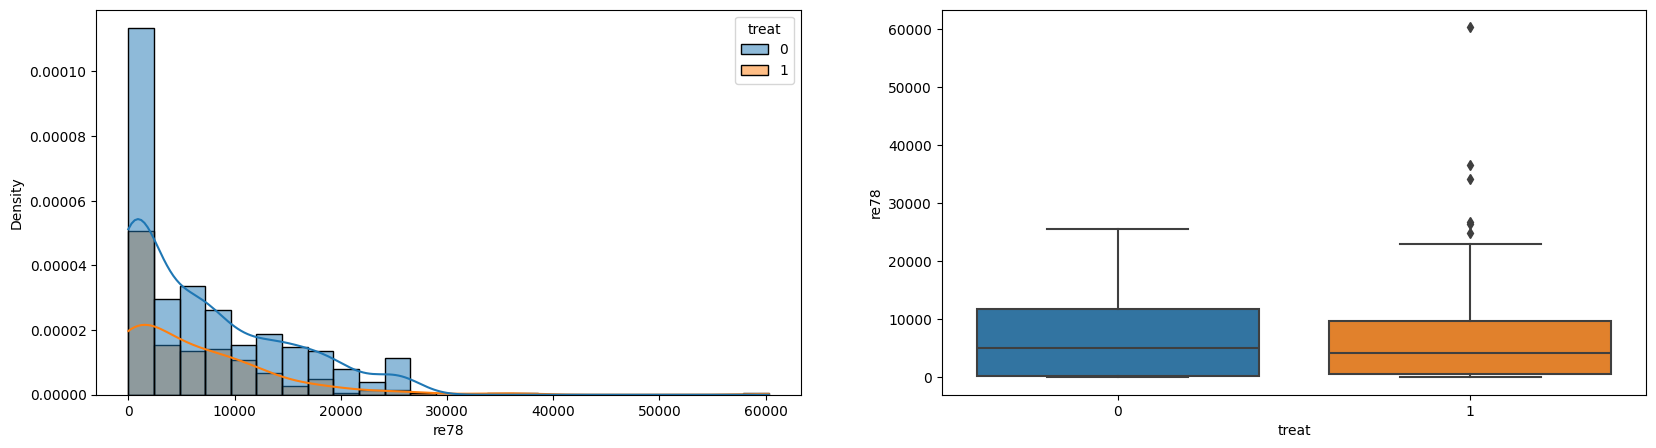

In [4]:
# Histogram/ KDE and boxplot
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.histplot(data=df, x="re78", hue="treat", kde=True, stat="density", ax=ax[0]);
sns.boxplot(data=df, y="re78", x="treat", ax=ax[1]);

We can see the that the median and mean earning are higher from the boxplots. However, both the histograms and the boxplots reveal that that the distribution of salaries of non-participants has a higher a heavier right-tail with more very high salaries.

In [5]:
# Linear Regression
formula = "re78 ~ C(treat)"
print(smf.ols(formula, data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Thu, 09 Nov 2023   Prob (F-statistic):              0.334
Time:                        18:39:33   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6984.1697    360.710     19.362

Our linear regression with the binary feature of whether a participant has received a training recovers the means in the two groups. If `treat=0`, then we predict `6984`, otherwise we predict `6984-635`. Thus, there seems to be a **negative correlation between the partipaction in the seminar and the total earning**.

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

---

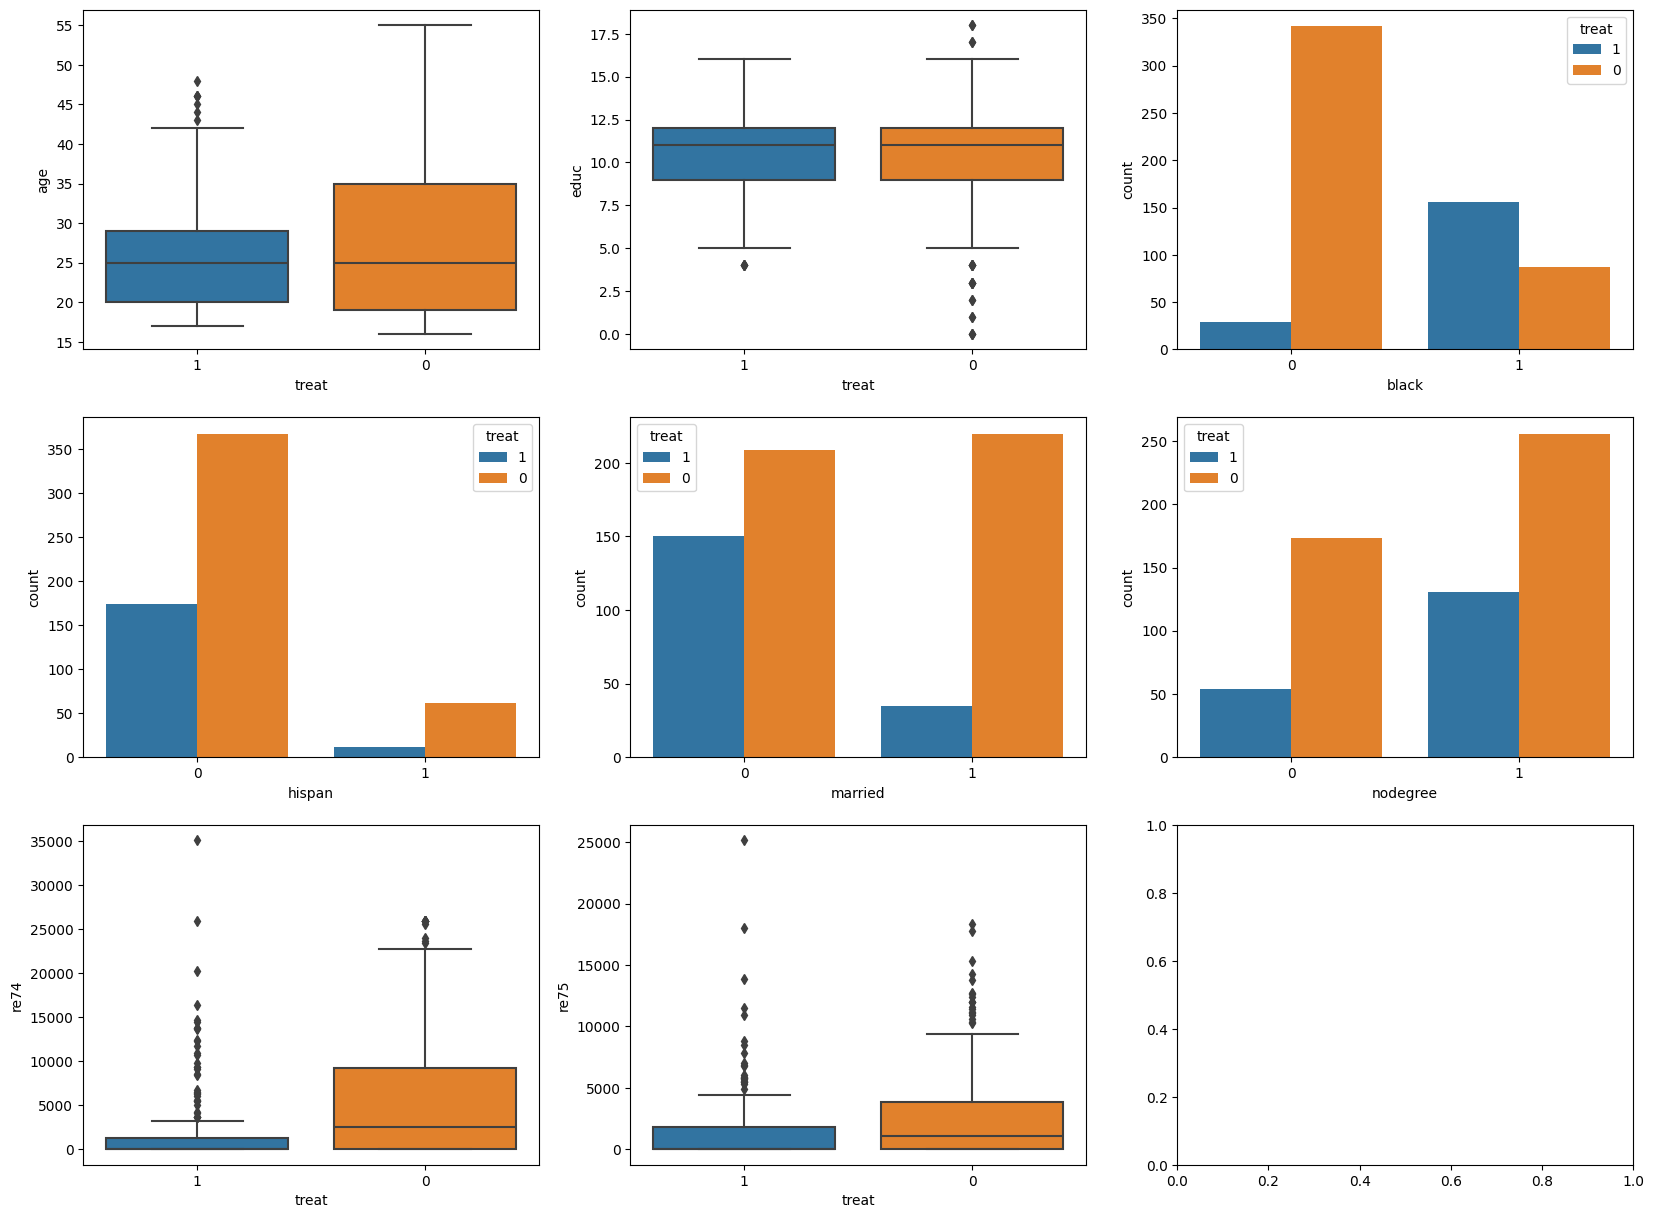

In [6]:
features = ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]
are_continuous= [1, 1, 0, 0, 0, 0, 1, 1]

tmp = df.copy()
tmp["treat"] = tmp["treat"].astype(str)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for feature, is_continuous, ax in zip(features, are_continuous, axs.flatten()):
    if is_continuous:
        sns.boxplot(tmp, y=feature, x="treat", ax=ax)
    else:
        sns.countplot(tmp, x=feature, hue="treat", ax=ax)

We observe that the feature distributions differ a lot between the treatment and non-treatment group. For example, the treatment gruop has more black people than non-black, while the non-treatment gruop has more non-black people than black people. Also, while there are almost as many married to non-married people in the non-treatment group, there are very little married people in the treatment group. It is possible that the effect that we measured in Exercise 1) - the fact that not attending the seminar leads to higher earnings - may be explained by the difference in demographics in the two gruops.

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

---

In [7]:
# Standardise continuos features
for feat in [f for f, c in zip(features, are_continuous) if c]:
    df[feat] = (df[feat] - df[feat].mean()) / df[feat].std()

# Fitting the propensity score model (predicting probability of receiving the treatment based on features)
formula = f"treat ~ {' + '.join([f if c else f'C({f})' for f, c in zip(features, are_continuous)])}"
model = smf.logit(formula, data=df).fit()

print(model.summary())

# Compute propensity scores for all samples
df["propensity"] = model.predict(df)

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 09 Nov 2023   Pseudo R-squ.:                  0.3508
Time:                        18:39:34   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [8]:
# Build graph of all people in similarity (absolute difference)
similarity_score = lambda x, y : 1-abs(x-y)

treatment_df = df[treatment]
control_df = df[~treatment]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():
        similarity = similarity_score(control_row['propensity'], treatment_row['propensity'])
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [9]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df = df.iloc[matched]

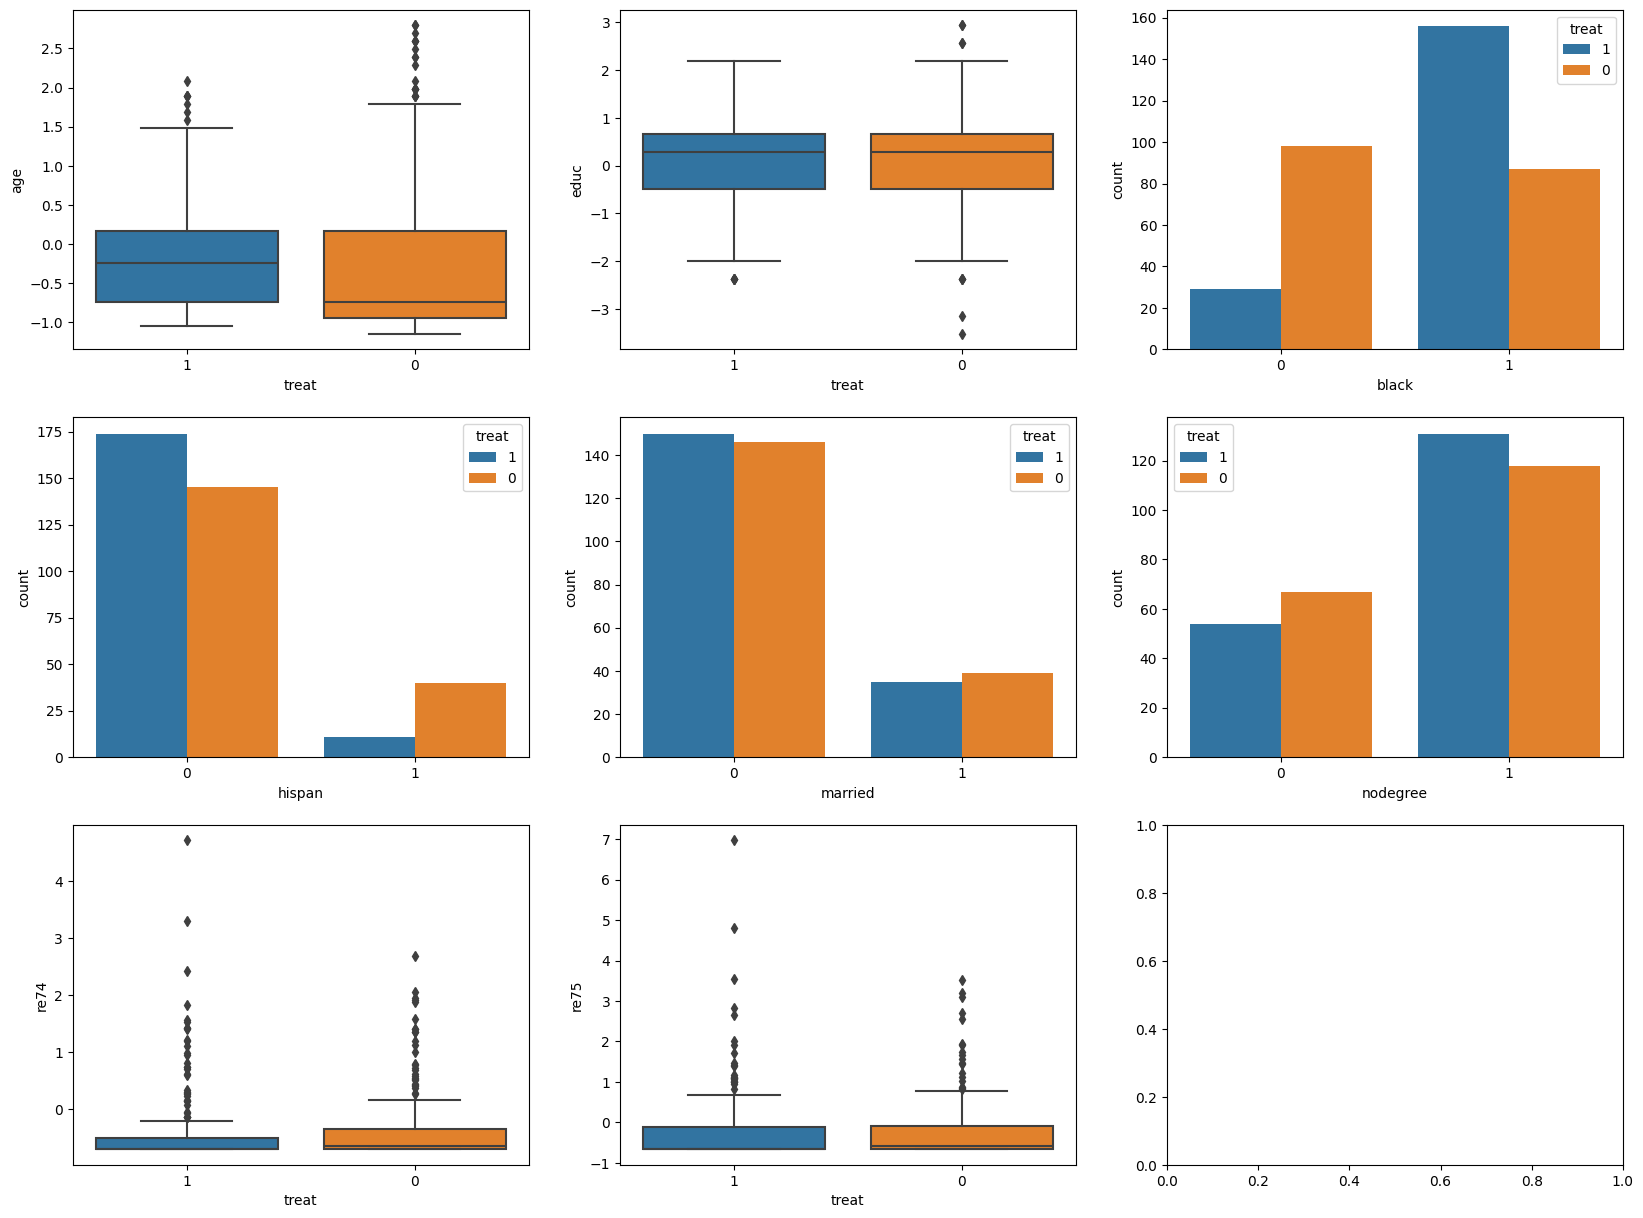

In [10]:
tmp = balanced_df.copy()
tmp["treat"] = tmp["treat"].astype(str)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for feature, is_continuous, ax in zip(features, are_continuous, axs.flatten()):
    if is_continuous:
        sns.boxplot(tmp, y=feature, x="treat", ax=ax)
    else:
        sns.countplot(tmp, x=feature, hue="treat", ax=ax)

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

---

We can see that there are some 

In [11]:
G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black'])\
            and (control_row['hispan'] == treatment_row['hispan']):
            similarity = similarity_score(control_row['propensity'],
                                        treatment_row['propensity'])

            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)

In [12]:
matched = [i[0] for i in matching] + [i[1] for i in matching]
balanced_df = df.iloc[matched]

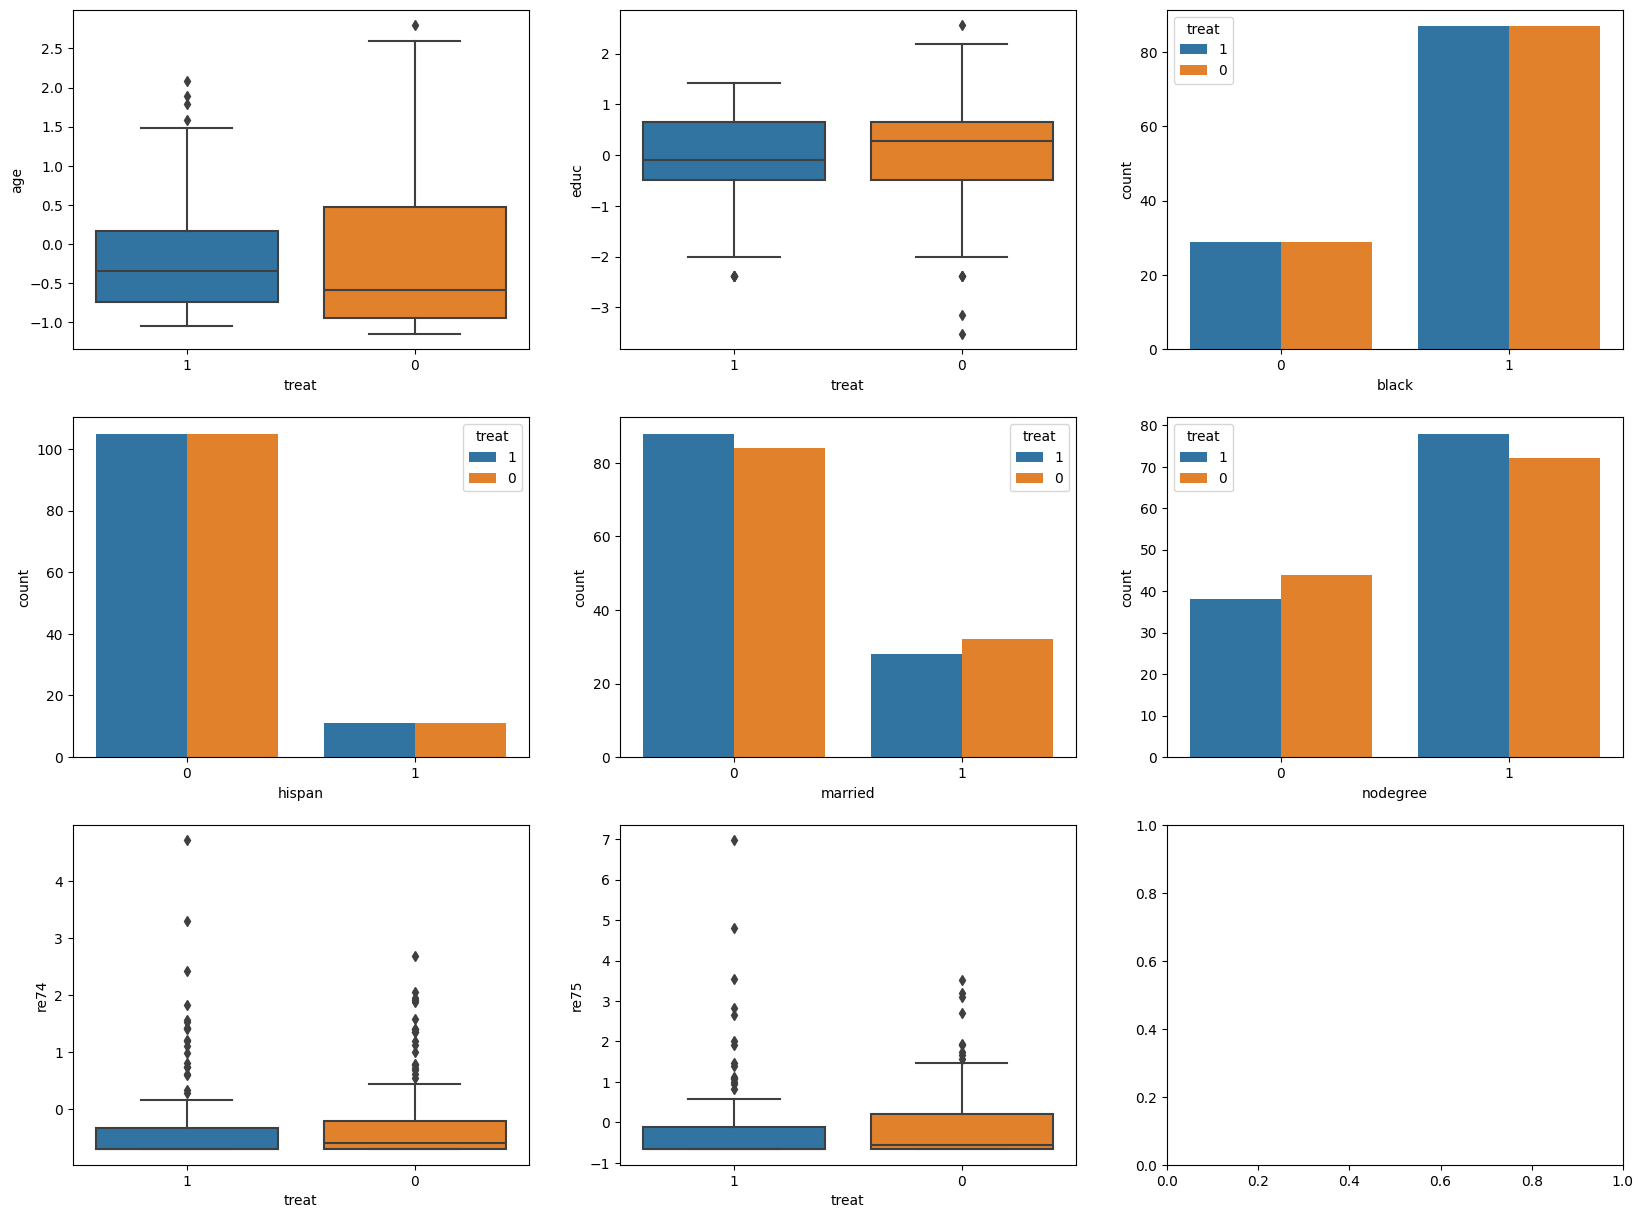

In [13]:
tmp = balanced_df.copy()
tmp["treat"] = tmp["treat"].astype(str)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for feature, is_continuous, ax in zip(features, are_continuous, axs.flatten()):
    if is_continuous:
        sns.boxplot(tmp, y=feature, x="treat", ax=ax)
    else:
        sns.countplot(tmp, x=feature, hue="treat", ax=ax)

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

---

In [14]:
# Numerical summaries
treat = balanced_df[balanced_df.treat == 1]["re78"].describe().rename("With Training")
no_treat = balanced_df[balanced_df.treat == 0]["re78"].describe().rename("No Training")
pd.concat([treat, no_treat], axis=1)

,With Training,No Training
count,116.000000,116.000000
mean,6375.738003,5095.456025
std,6670.986821,6047.014862
min,0.000000,0.000000
25%,758.102600,0.000000
50%,4648.736000,2256.488500
75%,10160.440000,8942.092750
max,36646.950000,20243.380000


We re-run the linear regression analysis from Exercise 1 while accounting for possible confounding variables.

In [15]:
# Linear regression of re78 ~ treat
formula = "re78 ~ treat"
model = smf.ols(formula, data=balanced_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.345
Date:                Thu, 09 Nov 2023   Prob (F-statistic):              0.127
Time:                        18:40:08   Log-Likelihood:                -2360.2
No. Observations:                 232   AIC:                             4724.
Df Residuals:                     230   BIC:                             4731.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5095.4560    591.129      8.620      0.0

The conclusion reverses. The workshops do indeed seem to have an effect and increased the salary in the treatment group. Note: It seeems like we can also hold all other possibly confounding variables constant by running the regression analysis over all variables. In this way the coefficient for the treatment variable should be interpreted as the effect of the treatment on the salary, while holding all other variables constant (e.g. at the mean value).

In [16]:
formula = f"re78 ~ treat + {' + '.join([f if c else f'C({f})' for f, c in zip(features, are_continuous)])}"
model = smf.ols(formula, data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           5.99e-17
Time:                        18:40:08   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         6426.2110    750.734  